# RTMO Pose Estimation with rtmlib

**Advantages of rtmlib:**
- No mmcv, mmpose, or mmdet dependencies required
- Simple, lightweight interface
- Direct ONNX model support
- One-stage detection (no separate detector needed)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
import pandas as pd

from rtmlib import RTMO, draw_skeleton

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

## Model Configuration

We'll compare RTMO-s and RTMO-m with different threshold configurations:
- **score_thr**: Minimum confidence score to keep a detection
- **nms_thr**: IoU threshold for Non-Maximum Suppression (higher = keeps more overlapping detections)


In [33]:
MODELS = [
    # RTMO-s with MMPose defaults (most permissive)
    {
        'name': 'RTMO-s (MMPose)',
        'model_type': 's',
        'onnx_model': 'https://download.openmmlab.com/mmpose/v1/projects/rtmo/onnx_sdk/rtmo-s_8xb32-600e_body7-640x640-dac2bf74_20231211.zip',
        'input_size': (640, 640),
        'score_thr': 0.1,
        'nms_thr': 0.65,
        'description': 'MMPose test_cfg defaults'
    },
    # RTMO-s with moderate thresholds
    {
        'name': 'RTMO-s (Moderate)',
        'model_type': 's',
        'onnx_model': 'https://download.openmmlab.com/mmpose/v1/projects/rtmo/onnx_sdk/rtmo-s_8xb32-600e_body7-640x640-dac2bf74_20231211.zip',
        'input_size': (640, 640),
        'score_thr': 0.2,
        'nms_thr': 0.45,
        'description': 'Moderate thresholds (balanced)'
    },
    # RTMO-s with rtmlib defaults (most strict)
    {
        'name': 'RTMO-s (rtmlib)',
        'model_type': 's',
        'onnx_model': 'https://download.openmmlab.com/mmpose/v1/projects/rtmo/onnx_sdk/rtmo-s_8xb32-600e_body7-640x640-dac2bf74_20231211.zip',
        'input_size': (640, 640),
        'score_thr': 0.7,
        'nms_thr': 0.45,
        'description': 'rtmlib class defaults'
    },
    # RTMO-m with MMPose defaults
    {
        'name': 'RTMO-m (MMPose)',
        'model_type': 'm',
        'onnx_model': 'https://download.openmmlab.com/mmpose/v1/projects/rtmo/onnx_sdk/rtmo-m_16xb16-600e_body7-640x640-39e78cc4_20231211.zip',
        'input_size': (640, 640),
        'score_thr': 0.1,
        'nms_thr': 0.65,
        'description': 'MMPose test_cfg defaults'
    },
    # RTMO-m with moderate thresholds
    {
        'name': 'RTMO-m (Moderate)',
        'model_type': 'm',
        'onnx_model': 'https://download.openmmlab.com/mmpose/v1/projects/rtmo/onnx_sdk/rtmo-m_16xb16-600e_body7-640x640-39e78cc4_20231211.zip',
        'input_size': (640, 640),
        'score_thr': 0.2,
        'nms_thr': 0.45,
        'description': 'Moderate thresholds (balanced)'
    },
    # RTMO-m with rtmlib defaults
    {
        'name': 'RTMO-m (rtmlib)',
        'model_type': 'm',
        'onnx_model': 'https://download.openmmlab.com/mmpose/v1/projects/rtmo/onnx_sdk/rtmo-m_16xb16-600e_body7-640x640-39e78cc4_20231211.zip',
        'input_size': (640, 640),
        'score_thr': 0.7,
        'nms_thr': 0.45,
        'description': 'rtmlib class defaults'
    }
]

DEVICE = 'cpu'  # Options: 'cpu', 'cuda', 'mps'
BACKEND = 'onnxruntime'  # Options: 'opencv', 'onnxruntime', 'openvino'

print("RTMO Model Configurations to test:")
print(f"{'Model':<25} {'score_thr':<12} {'nms_thr':<10} {'Description':<30}")
print("=" * 80)
for model in MODELS:
    print(f"{model['name']:<25} {model['score_thr']:<12} {model['nms_thr']:<10} {model['description']:<30}")

print(f"\nDevice: {DEVICE}")
print(f"Backend: {BACKEND}")


RTMO Model Configurations to test:
Model                     score_thr    nms_thr    Description                   
RTMO-s (MMPose)           0.1          0.65       MMPose test_cfg defaults      
RTMO-s (Moderate)         0.2          0.45       Moderate thresholds (balanced)
RTMO-s (rtmlib)           0.7          0.45       rtmlib class defaults         
RTMO-m (MMPose)           0.1          0.65       MMPose test_cfg defaults      
RTMO-m (Moderate)         0.2          0.45       Moderate thresholds (balanced)
RTMO-m (rtmlib)           0.7          0.45       rtmlib class defaults         

Device: cpu
Backend: onnxruntime


## Video Discovery

In [28]:
def extract_shot_type(video_path):
    # Format: joined_{ShotType}_{clips}_{timestamp}.mp4
    parts = video_path.stem.split('_')
    shot_parts = []
    for part in parts[1:]:  # Skip 'joined'
        if part.isdigit() or part.endswith('clips'):
            break
        shot_parts.append(part)
    return '_'.join(shot_parts)

def print_video_info(video_path):
    cap = cv2.VideoCapture(str(video_path))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = frame_count / fps if fps > 0 else 0
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    
    shot_type = extract_shot_type(video_path)
    print(f"  {shot_type:20s} | {frame_count:4d} frames | {duration:5.1f}s | {width}x{height}")

dataset_path = Path("./dataset")
VIDEOS = sorted(list(dataset_path.glob("*.mp4")))

print(f"Found {len(VIDEOS)} videos:\n")
for video_path in VIDEOS:
    print_video_info(video_path)

Found 8 videos:

  Backhand             |  224 frames |   7.5s | 1920x1080
  Backhand_Volley      |  374 frames |  12.5s | 1920x1080
  Contrapared          |   42 frames |   1.4s | 1920x1080
  Forehand             |  349 frames |  11.6s | 1920x1080
  Forehand_Volley      |  184 frames |   6.1s | 1920x1080
  Lob                  |  223 frames |   7.4s | 1920x1080
  Smash                |  147 frames |   4.9s | 1920x1080
  Vibora               |  234 frames |   7.8s | 1920x1080


## Load Models

In [34]:
def load_rtmo_models():
    """Load RTMO models directly - not using Body API wrapper"""
    print("Loading RTMO models directly...\n")
    
    for model_config in MODELS:
        print(f"  Loading {model_config['name']}...", end=" ")
        
        try:
            # Initialize RTMO model directly
            rtmo_model = RTMO(
                onnx_model=model_config['onnx_model'],
                model_input_size=model_config['input_size'],
                backend=BACKEND,
                device=DEVICE,
                nms_thr=model_config.get('nms_thr', 0.45),
                score_thr=model_config.get('score_thr', 0.7),
            )
            
            model_config['model'] = rtmo_model
            print("✓")
            
        except Exception as e:
            print(f"✗ Error: {e}")
            model_config['model'] = None
    
    print("\nAll models loaded!")

load_rtmo_models()

Loading RTMO models directly...

  Loading RTMO-s (MMPose)... load /Users/roberto/.cache/rtmlib/hub/checkpoints/rtmo-s_8xb32-600e_body7-640x640-dac2bf74_20231211.onnx with onnxruntime backend
✓
  Loading RTMO-s (Moderate)... load /Users/roberto/.cache/rtmlib/hub/checkpoints/rtmo-s_8xb32-600e_body7-640x640-dac2bf74_20231211.onnx with onnxruntime backend
✓
  Loading RTMO-s (rtmlib)... load /Users/roberto/.cache/rtmlib/hub/checkpoints/rtmo-s_8xb32-600e_body7-640x640-dac2bf74_20231211.onnx with onnxruntime backend
✓
  Loading RTMO-m (MMPose)... load /Users/roberto/.cache/rtmlib/hub/checkpoints/rtmo-m_16xb16-600e_body7-640x640-39e78cc4_20231211.onnx with onnxruntime backend
✓
  Loading RTMO-m (Moderate)... load /Users/roberto/.cache/rtmlib/hub/checkpoints/rtmo-m_16xb16-600e_body7-640x640-39e78cc4_20231211.onnx with onnxruntime backend
✓
  Loading RTMO-m (rtmlib)... load /Users/roberto/.cache/rtmlib/hub/checkpoints/rtmo-m_16xb16-600e_body7-640x640-39e78cc4_20231211.onnx with onnxruntime back

In [35]:
def benchmark_rtmo_on_video(rtmo_model, model_name, video_path, max_frames=100):
    cap = cv2.VideoCapture(str(video_path))
    
    metrics = {
        'model_name': model_name,
        'video': video_path.name,
        'frames_processed': 0,
        'frame_times': [],
        'people_detected': [],
        'total_people': 0,
        'confidence_scores': []
    }
    
    frame_count = 0
    
    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        # RTMO expects BGR input (OpenCV default), no color conversion needed
        frame_bgr = frame
        
        # Run inference and time it
        start_time = time.time()
        keypoints, scores = rtmo_model(frame_bgr)
        inference_time = time.time() - start_time
        
        metrics['frame_times'].append(inference_time)
        
        # Count detected people and collect confidence scores
        num_people = len(keypoints) if keypoints is not None else 0
        metrics['people_detected'].append(num_people)
        metrics['total_people'] += num_people
        
        # Collect confidence scores
        if scores is not None and len(scores) > 0:
            # Average confidence across all keypoints for each person
            for person_scores in scores:
                avg_confidence = np.mean(person_scores)
                metrics['confidence_scores'].append(avg_confidence)
        
        metrics['frames_processed'] += 1
        frame_count += 1
    
    cap.release()
    
    # Calculate summary statistics
    if metrics['frame_times']:
        metrics['avg_inference_time'] = np.mean(metrics['frame_times'])
        metrics['std_inference_time'] = np.std(metrics['frame_times'])
        metrics['fps'] = 1.0 / metrics['avg_inference_time']
    
    if metrics['people_detected']:
        metrics['avg_people_per_frame'] = np.mean(metrics['people_detected'])
        metrics['max_people_per_frame'] = max(metrics['people_detected'])
    
    if metrics['confidence_scores']:
        metrics['avg_confidence'] = np.mean(metrics['confidence_scores'])
        metrics['min_confidence'] = min(metrics['confidence_scores'])
    
    return metrics

## Run Benchmarks

In [36]:
FRAMES_TO_PROCESS = 100
all_results = []

print(f"Running benchmarks (processing {FRAMES_TO_PROCESS} frames per video)...\n")

for model_config in MODELS:
    model = model_config['model']
    model_name = model_config['name']
    
    print(f"\n{'='*60}")
    print(f"Testing: {model_config['name']}")
    print(f"{'='*60}\n")
    
    for video_path in VIDEOS:
        print(f"  Processing  {video_path.name}...", end=" ")
        
        metrics = benchmark_rtmo_on_video(
            model,
            model_name,
            video_path,
            max_frames=FRAMES_TO_PROCESS
        )

        metrics['shot_type'] = extract_shot_type(video_path)
        all_results.append(metrics)
        
        print(f"✓ ({metrics['fps']:.1f} FPS, {metrics['avg_people_per_frame']:.1f} people/frame)")
            

print(f"Benchmarking complete! Collected {len(all_results)} results.")

Running benchmarks (processing 100 frames per video)...


Testing: RTMO-s (MMPose)

  Processing  joined_Backhand_15clips_20251103_210348.mp4... ✓ (20.3 FPS, 5.4 people/frame)
  Processing  joined_Backhand_Volley_29clips_20251103_210348.mp4... ✓ (20.3 FPS, 5.4 people/frame)
  Processing  joined_Backhand_Volley_29clips_20251103_210348.mp4... ✓ (20.2 FPS, 5.9 people/frame)
  Processing  joined_Contrapared_3clips_20251103_210348.mp4... ✓ (20.2 FPS, 5.9 people/frame)
  Processing  joined_Contrapared_3clips_20251103_210348.mp4... ✓ (20.8 FPS, 6.8 people/frame)
  Processing  joined_Forehand_25clips_20251103_210348.mp4... ✓ (20.8 FPS, 6.8 people/frame)
  Processing  joined_Forehand_25clips_20251103_210348.mp4... ✓ (20.4 FPS, 5.4 people/frame)
  Processing  joined_Forehand_Volley_14clips_20251103_210349.mp4... ✓ (20.4 FPS, 5.4 people/frame)
  Processing  joined_Forehand_Volley_14clips_20251103_210349.mp4... ✓ (19.9 FPS, 6.3 people/frame)
  Processing  joined_Lob_15clips_20251103_210349.mp4... 

## Results Summary

In [37]:
# Create DataFrame from results
df_results = pd.DataFrame(all_results)

# Display summary
summary = df_results.groupby('model_name').agg({
    'fps': ['mean', 'std'],
    'avg_people_per_frame': 'mean',
    'avg_confidence': 'mean',
}).round(2)

print("\nModel Performance Summary:")
print(summary)


Model Performance Summary:
                     fps       avg_people_per_frame avg_confidence
                    mean   std                 mean           mean
model_name                                                        
RTMO-m (MMPose)     8.80  0.15                 7.62           0.59
RTMO-m (Moderate)   8.72  0.13                 4.56           0.65
RTMO-m (rtmlib)     8.79  0.06                 1.36           0.52
RTMO-s (MMPose)    20.32  0.23                 6.25           0.70
RTMO-s (Moderate)  20.01  0.59                 3.91           0.73
RTMO-s (rtmlib)    19.65  0.19                 1.29           0.50


## Visualizations

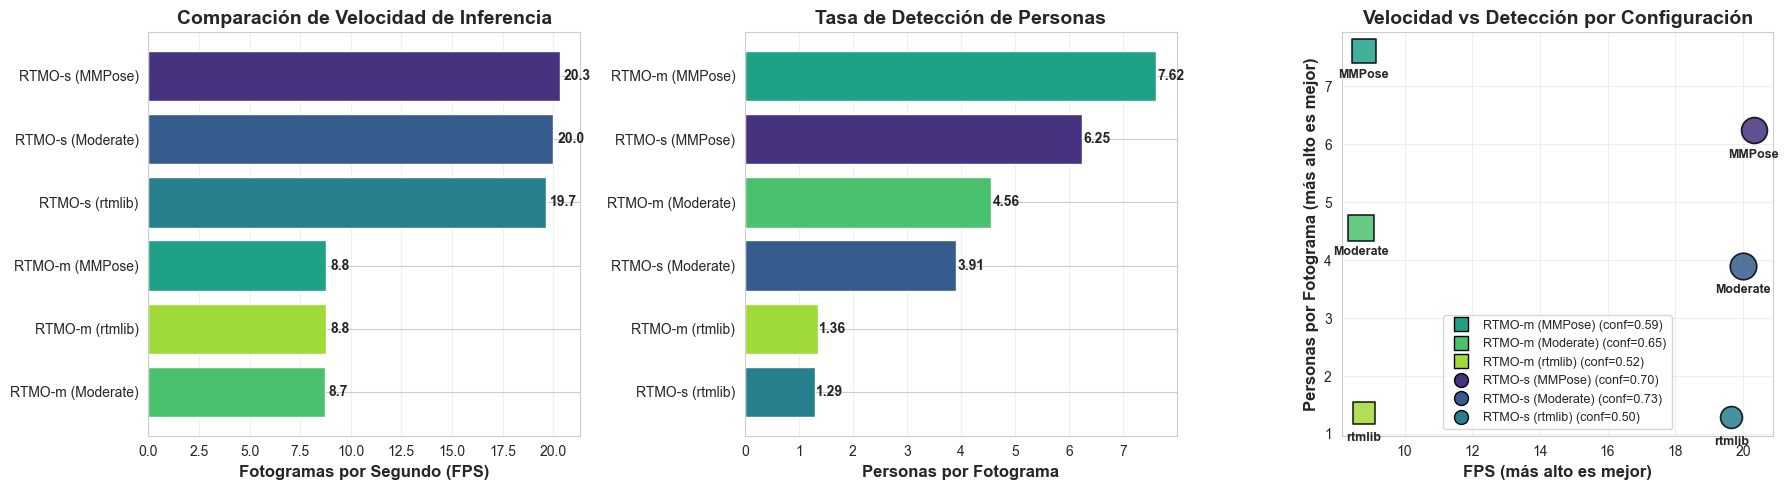

In [47]:
# Aggregate metrics by model configuration
df_by_model = df_results.groupby('model_name').agg({
    'fps': 'mean',
    'avg_people_per_frame': 'mean',
    'avg_confidence': 'mean',
    'avg_inference_time': 'mean'
}).reset_index()
df_by_model['avg_inference_ms'] = df_by_model['avg_inference_time'] * 1000

# Color scheme: different colors for model sizes, different shades for threshold configs
# RTMO-s: blues (viridis 0.2-0.4), RTMO-m: greens/yellows (viridis 0.6-0.8)
palette = sns.color_palette("viridis", n_colors=6)
color_map = {
    'RTMO-s (MMPose)': palette[0],
    'RTMO-s (Moderate)': palette[1],
    'RTMO-s (rtmlib)': palette[2],
    'RTMO-m (MMPose)': palette[3],
    'RTMO-m (Moderate)': palette[4],
    'RTMO-m (rtmlib)': palette[5]
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: FPS comparison (horizontal bar)
ax1 = axes[0]
fps_sorted = df_by_model.sort_values('fps', ascending=True)
colors_fps = [color_map[name] for name in fps_sorted['model_name']]
bars = ax1.barh(fps_sorted['model_name'], fps_sorted['fps'], color=colors_fps)
ax1.set_xlabel('Fotogramas por Segundo (FPS)', fontsize=12, fontweight='bold')
ax1.set_title('Comparación de Velocidad de Inferencia', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for bar in bars:
    width = bar.get_width()
    ax1.text(width + 0.2, bar.get_y() + bar.get_height()/2, f'{width:.1f}',
             va='center', fontsize=10, fontweight='bold')

# Plot 2: People detected per frame
ax2 = axes[1]
people_sorted = df_by_model.sort_values('avg_people_per_frame', ascending=True)
colors_people = [color_map[name] for name in people_sorted['model_name']]
bars2 = ax2.barh(people_sorted['model_name'], people_sorted['avg_people_per_frame'], color=colors_people)
ax2.set_xlabel('Personas por Fotograma', fontsize=12, fontweight='bold')
ax2.set_title('Tasa de Detección de Personas', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for bar in bars2:
    width = bar.get_width()
    ax2.text(width + 0.02, bar.get_y() + bar.get_height()/2, f'{width:.2f}',
             va='center', fontsize=10, fontweight='bold')

# Plot 3: Scatter FPS vs people with marker size = confidence
ax3 = axes[2]
colors_scatter = [color_map[name] for name in df_by_model['model_name']]

# Different markers for different model sizes
markers = {'s': 'o', 'm': 's'}  # circle for RTMO-s, square for RTMO-m

for _, row in df_by_model.iterrows():
    model_type = 's' if 'RTMO-s' in row['model_name'] else 'm'
    ax3.scatter(
        row['fps'],
        row['avg_people_per_frame'],
        s=row['avg_confidence'] * 500,
        c=[color_map[row['model_name']]],
        alpha=0.85,
        edgecolors='black',
        linewidth=1.2,
        marker=markers[model_type]
    )
    
    # Annotate with threshold configuration
    config_label = row['model_name'].split('(')[1].rstrip(')')
    ax3.annotate(config_label, (row['fps'], row['avg_people_per_frame']),
                textcoords='offset points', xytext=(0, -20), ha='center', 
                fontsize=9, fontweight='bold')

legend_handles = [
    plt.Line2D([0], [0], marker=markers['s' if 'RTMO-s' in row['model_name'] else 'm'], 
               color='w', label=f"{row['model_name']} (conf={row['avg_confidence']:.2f})",
               markerfacecolor=color_map[row['model_name']], 
               markeredgecolor='black', markersize=10)
    for _, row in df_by_model.iterrows()
]
ax3.legend(handles=legend_handles, fontsize=9, loc='best')
ax3.set_xlabel('FPS (más alto es mejor)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Personas por Fotograma (más alto es mejor)', fontsize=12, fontweight='bold')
ax3.set_title('Velocidad vs Detección por Configuración', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Pose Detection Samples

Visualizing detection results across all videos using RTMO-s with Moderate thresholds (score_thr=0.2, nms_thr=0.45).


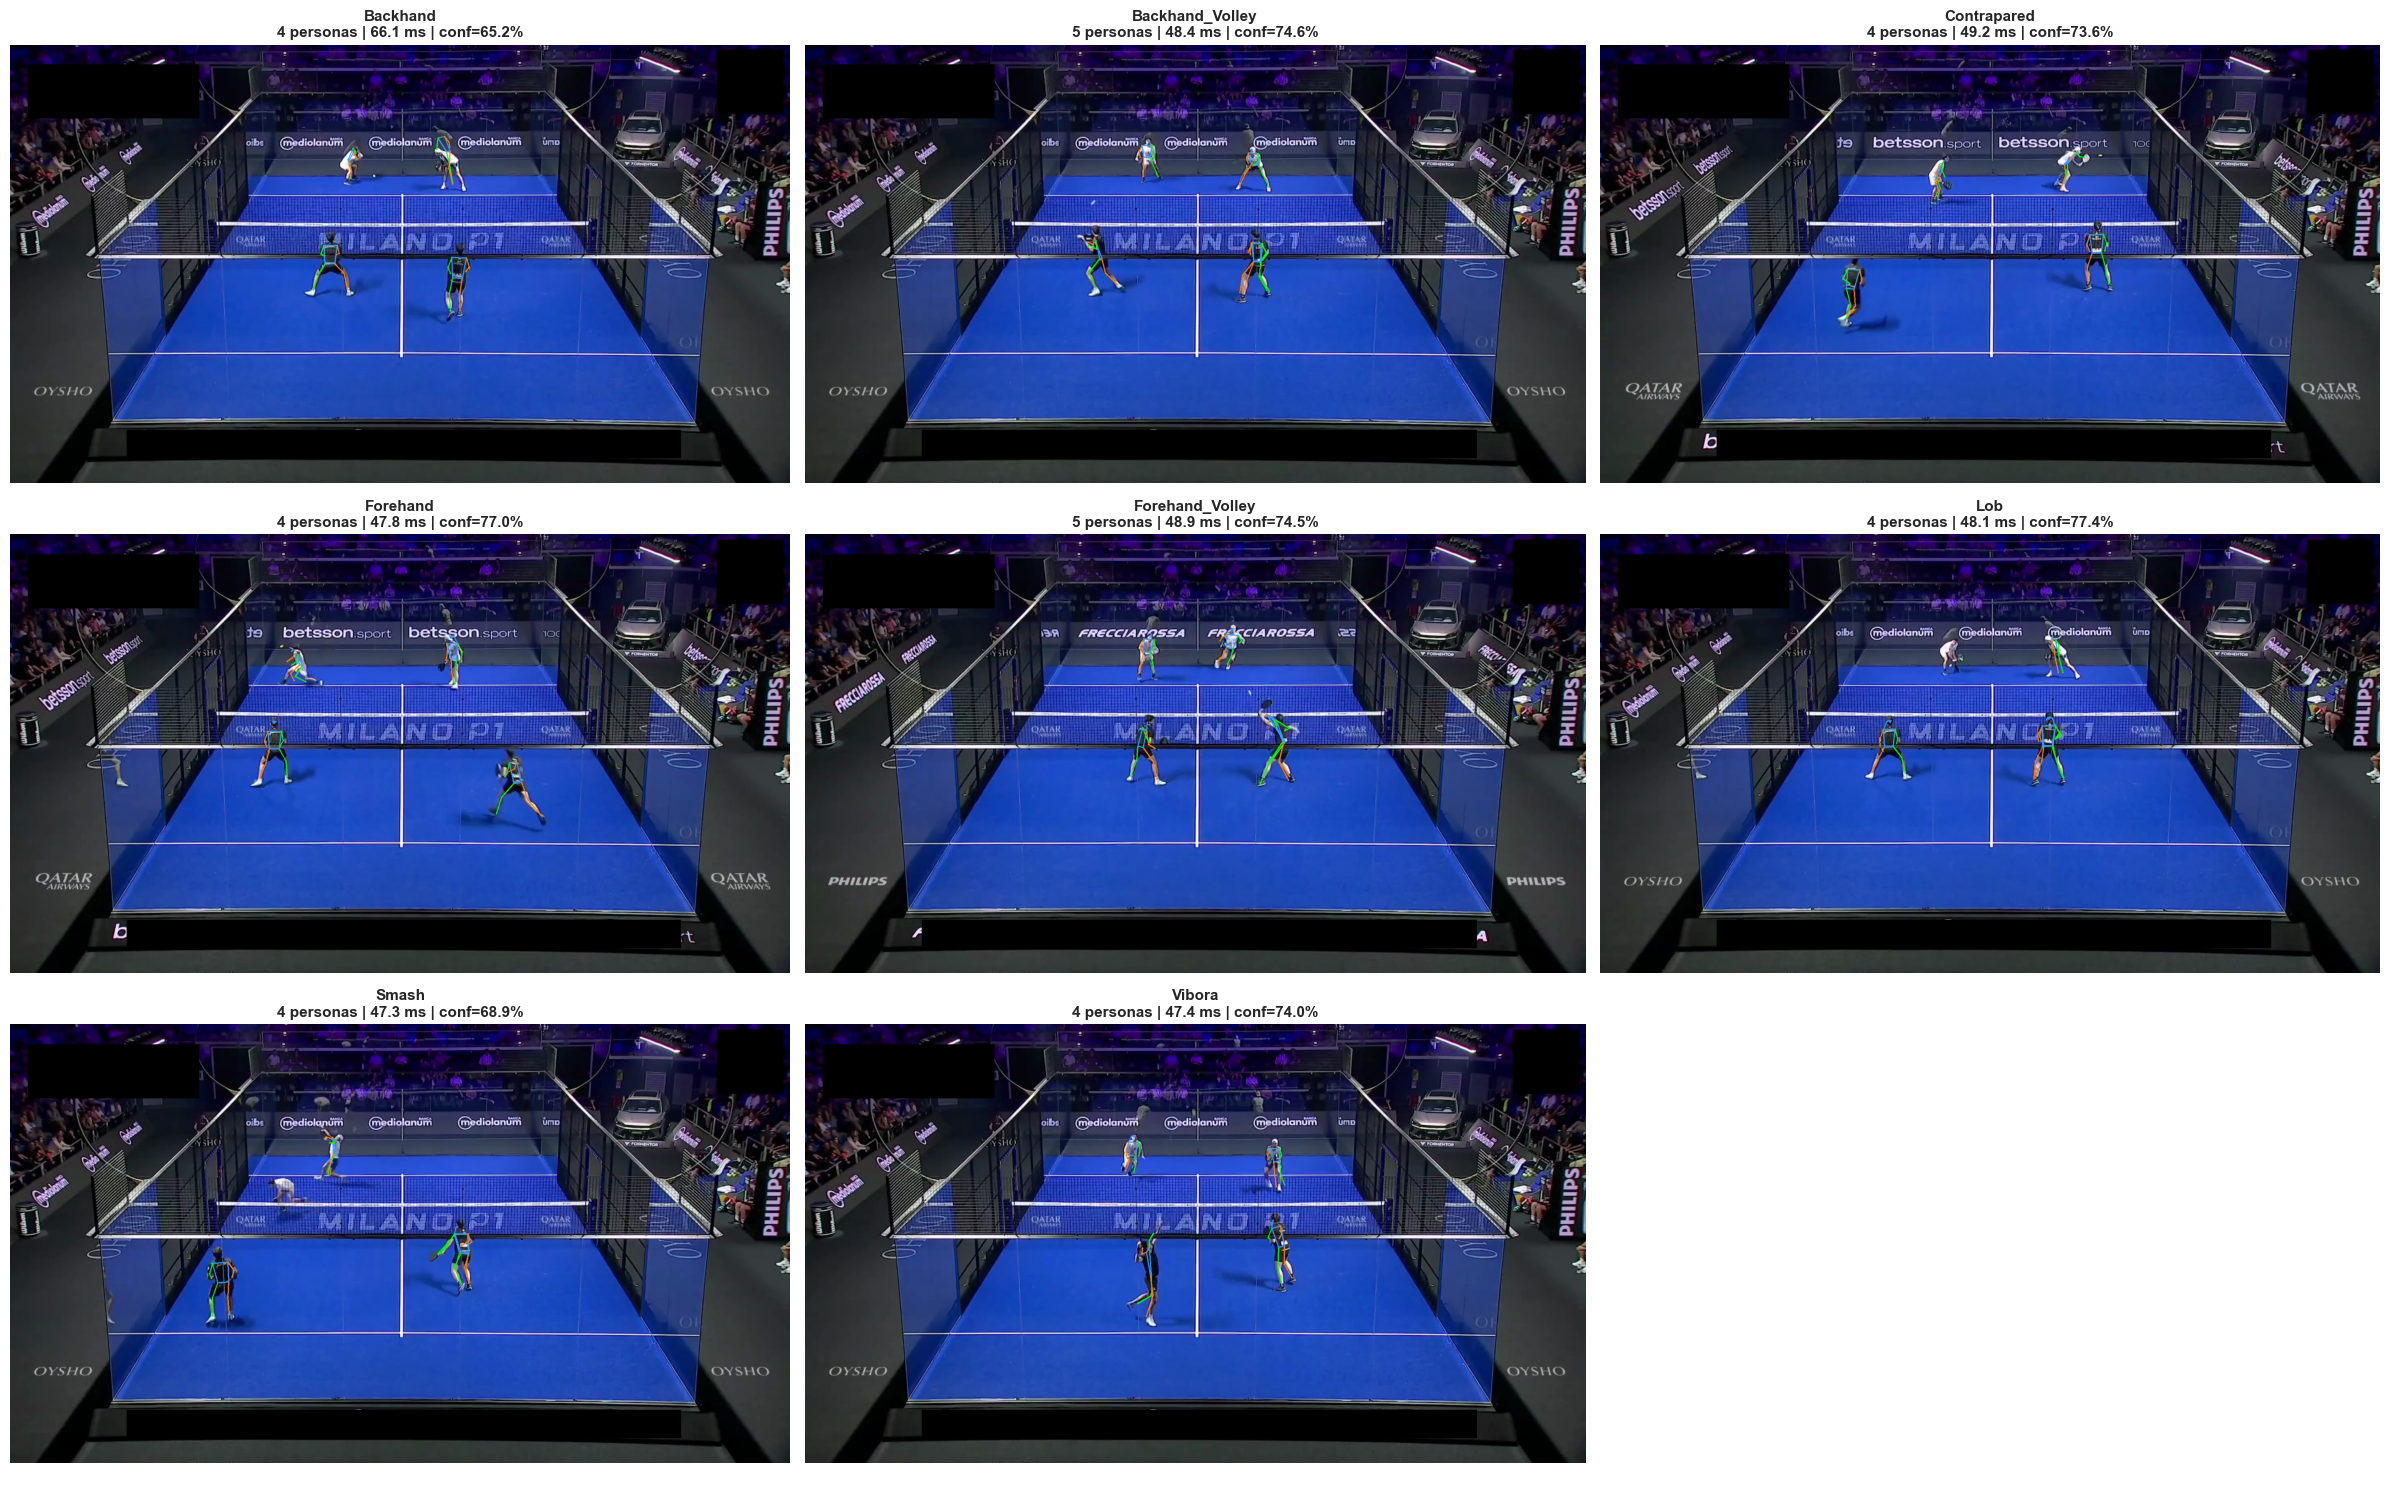


Procesadas 8 muestras con RTMO-s (Moderate)


In [49]:
# Use RTMO-s (Moderate) for samples
rtmo_s_model = MODELS[1]['model']
model_name = MODELS[1]['name']

# Process one frame from each video
num_videos = len(VIDEOS)
cols = 3
rows = (num_videos + cols - 1) // cols  # Ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 5 * rows))
axes = axes.flatten() if num_videos > 1 else [axes]

for idx, video_path in enumerate(VIDEOS):
    cap = cv2.VideoCapture(str(video_path))
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        # Convert for visualization
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Run inference
        start_time = time.time()
        keypoints, scores = rtmo_s_model(frame)
        inference_ms = (time.time() - start_time) * 1000
        
        # Calculate metrics
        num_people = len(keypoints) if keypoints is not None else 0
        avg_conf = float(np.mean(scores)) if scores is not None and len(scores) > 0 else 0.0
        
        # Draw skeleton
        frame_annotated = draw_skeleton(frame_rgb.copy(), keypoints, scores, kpt_thr=0.3)
        
        # Display
        axes[idx].imshow(frame_annotated)
        shot_type = extract_shot_type(video_path)
        title = (
            f"{shot_type}\n"
            f"{num_people} personas | {inference_ms:.1f} ms | conf={avg_conf*100:.1f}%"
        )
        axes[idx].set_title(title, fontsize=11, fontweight='bold')
        axes[idx].axis('off')
    else:
        axes[idx].axis('off')
        axes[idx].text(0.5, 0.5, 'Frame not available', ha='center', va='center')

# Hide unused subplots
for idx in range(num_videos, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\nProcesadas {num_videos} muestras con {model_name}")


## Model Comparison Table

Create a comprehensive comparison table.

In [51]:
# Create comparison table
comparison_data = []

for model_config in MODELS:
    model_results = df_results[df_results['model_name'] == model_config['name']]
    
    if len(model_results) > 0:
        comparison_data.append({
            'Model': model_config['name'],
            'Description': model_config['description'],
            'Avg FPS': model_results['fps'].mean(),
            'Std FPS': model_results['fps'].std(),
            'Avg People/Frame': model_results['avg_people_per_frame'].mean(),
            'Avg Confidence': model_results['avg_confidence'].mean(),
            'Total Frames': model_results['frames_processed'].sum()
        })

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.round(2)

df_comparison

Model                     Description  Avg FPS  Std FPS  \
0    RTMO-s (MMPose)        MMPose test_cfg defaults    20.32     0.23   
1  RTMO-s (Moderate)  Moderate thresholds (balanced)    20.01     0.59   
2    RTMO-s (rtmlib)           rtmlib class defaults    19.65     0.19   
3    RTMO-m (MMPose)        MMPose test_cfg defaults     8.80     0.15   
4  RTMO-m (Moderate)  Moderate thresholds (balanced)     8.72     0.13   
5    RTMO-m (rtmlib)           rtmlib class defaults     8.79     0.06   

   Avg People/Frame  Avg Confidence  Total Frames  
0              6.25            0.70           742  
1              3.91            0.73           742  
2              1.29            0.50           742  
3              7.62            0.59           742  
4              4.56            0.65           742  
5              1.36            0.52           742

## Example End-to-End Video

In [55]:
def process_video_with_pose(rtmo_model, model_name, input_video_path, output_video_path, kpt_thr=0.3):
    """
    Process a video with pose estimation and save the annotated result.
    
    Args:
        rtmo_model: RTMO model instance
        model_name: Name of the model for display
        input_video_path: Path to input video
        output_video_path: Path to save annotated video
        kpt_thr: Keypoint confidence threshold for visualization
    """
    cap = cv2.VideoCapture(str(input_video_path))
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Create output directory if it doesn't exist
    output_video_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Initialize video writer with H.264 codec for better compatibility
    # Try 'avc1' first (H.264), fall back to 'mp4v' if not available
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    out = cv2.VideoWriter(str(output_video_path), fourcc, fps, (width, height))
    
    # Check if writer was successfully initialized
    if not out.isOpened():
        print("Warning: 'avc1' codec not available, trying 'mp4v'...")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(str(output_video_path), fourcc, fps, (width, height))
    
    print(f"Processing video: {input_video_path.name}")
    print(f"Resolution: {width}x{height}, FPS: {fps}, Frames: {total_frames}")
    print(f"Model: {model_name}")
    print(f"Output: {output_video_path}\n")
    
    frame_count = 0
    total_time = 0
    people_counts = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Run inference (RTMO expects BGR input from OpenCV)
        start_time = time.time()
        keypoints, scores = rtmo_model(frame)
        inference_time = time.time() - start_time
        total_time += inference_time
        
        # Convert to RGB for drawing
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Draw skeleton
        frame_annotated = draw_skeleton(frame_rgb, keypoints, scores, kpt_thr=kpt_thr)
        
        # Convert back to BGR for video writing
        frame_bgr = cv2.cvtColor(frame_annotated, cv2.COLOR_RGB2BGR)
        
        # Add info text
        num_people = len(keypoints) if keypoints is not None else 0
        people_counts.append(num_people)
        info_text = f"{model_name} | Frame {frame_count+1}/{total_frames} | {num_people} people | {inference_time*1000:.1f}ms"
        cv2.putText(frame_bgr, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.7, (0, 255, 0), 2, cv2.LINE_AA)
        
        # Write frame
        out.write(frame_bgr)
        
        frame_count += 1
        if frame_count % 50 == 0:
            avg_fps = frame_count / total_time
            print(f"  Processed {frame_count}/{total_frames} frames ({frame_count/total_frames*100:.1f}%) - {avg_fps:.1f} FPS")
    
    cap.release()
    out.release()
    
    # Print summary
    avg_fps = frame_count / total_time if total_time > 0 else 0
    avg_people = np.mean(people_counts) if people_counts else 0
    
    print("\n✓ Processing complete!")
    print(f"  Frames processed: {frame_count}")
    print(f"  Average FPS: {avg_fps:.2f}")
    print(f"  Average people detected: {avg_people:.2f}")
    print(f"  Total time: {total_time:.2f}s")
    print(f"  Video saved to: {output_video_path}")
    
    return {
        'frames_processed': frame_count,
        'total_time': total_time,
        'avg_fps': avg_fps,
        'avg_people': avg_people
    }

# Process the Vibora video with RTMO-s Moderate
input_video = Path("./dataset/joined_Vibora_13clips_20251103_210349.mp4")
output_video = Path("./out/annotated_Vibora_RTMO-s.mp4")

# Use RTMO-s Moderate model (balanced thresholds)
model_to_use = MODELS[1]  # RTMO-s (Moderate)

if input_video.exists():
    results = process_video_with_pose(
        rtmo_model=model_to_use['model'],
        model_name=model_to_use['name'],
        input_video_path=input_video,
        output_video_path=output_video,
        kpt_thr=0.3
    )
else:
    print(f"Error: Video not found at {input_video}")
    print(f"Available videos in dataset:")
    for v in sorted(Path("./dataset").glob("*.mp4")):
        print(f"  - {v.name}")

Processing video: joined_Vibora_13clips_20251103_210349.mp4
Resolution: 1920x1080, FPS: 30, Frames: 234
Model: RTMO-s (Moderate)
Output: out/annotated_Vibora_RTMO-s.mp4

  Processed 50/234 frames (21.4%) - 19.5 FPS
  Processed 50/234 frames (21.4%) - 19.5 FPS
  Processed 100/234 frames (42.7%) - 19.1 FPS
  Processed 100/234 frames (42.7%) - 19.1 FPS
  Processed 150/234 frames (64.1%) - 19.3 FPS
  Processed 150/234 frames (64.1%) - 19.3 FPS
  Processed 200/234 frames (85.5%) - 19.5 FPS
  Processed 200/234 frames (85.5%) - 19.5 FPS

✓ Processing complete!
  Frames processed: 234
  Average FPS: 19.06
  Average people detected: 4.26
  Total time: 12.28s
  Video saved to: out/annotated_Vibora_RTMO-s.mp4

✓ Processing complete!
  Frames processed: 234
  Average FPS: 19.06
  Average people detected: 4.26
  Total time: 12.28s
  Video saved to: out/annotated_Vibora_RTMO-s.mp4
